<a href="https://colab.research.google.com/github/dynhi/MachineLearning/blob/master/Lab8/SVM/4_Exercises_SVM_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM Exercises

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



- dataset: 'Titanic_train.csv', 'Titanic_test.csv'


Import libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
train_data = pd.read_csv('/content/drive/My Drive/Intro to AI/Lab 8/5-SVM/Titanic_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Intro to AI/Lab 8/5-SVM/Titanic_test.csv')

##Data Analysis

In [76]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
train_data.shape

(891, 12)

In [78]:
test_data.shape

(418, 11)

**The training-set has 891 examples and 11 features + the target variable (survived)**. 2 of the features are floats, 5 are integers and 5 are objects. Below I have listed the features with a short description:

In [79]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [80]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Above we can see that **38% out of the training-set survived the Titanic**. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the Age feature.

In [81]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


From the table above, we can note a few things. First of all, that we **need to convert a lot of features into numeric** ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the **features have widely different ranges**, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

**Let’s take a more detailed look at what data is actually missing:**

In [83]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent_1 = train_data.isnull().sum()/train_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the Age feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [84]:
train_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Above you can see the 11 features + the target variable (survived). **What features could contribute to a high survival rate?**
To me it would make sense if everything except `PassengerId`, `Ticket` and `Name` would be correlated with a high survival rate.

###Age and Sex

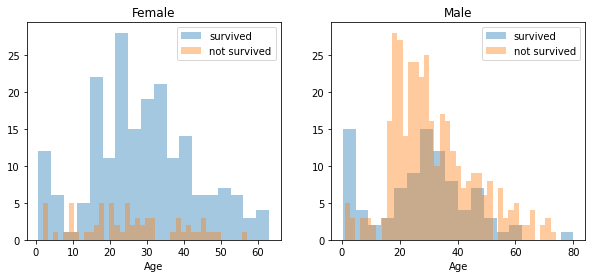

In [85]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.
For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.
Since there seem to be **certain ages, which have increased odds of survival** and because I want every feature to be roughly on the same scale, I will create age groups later on.

###Embarked, Pclass and Sex:

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


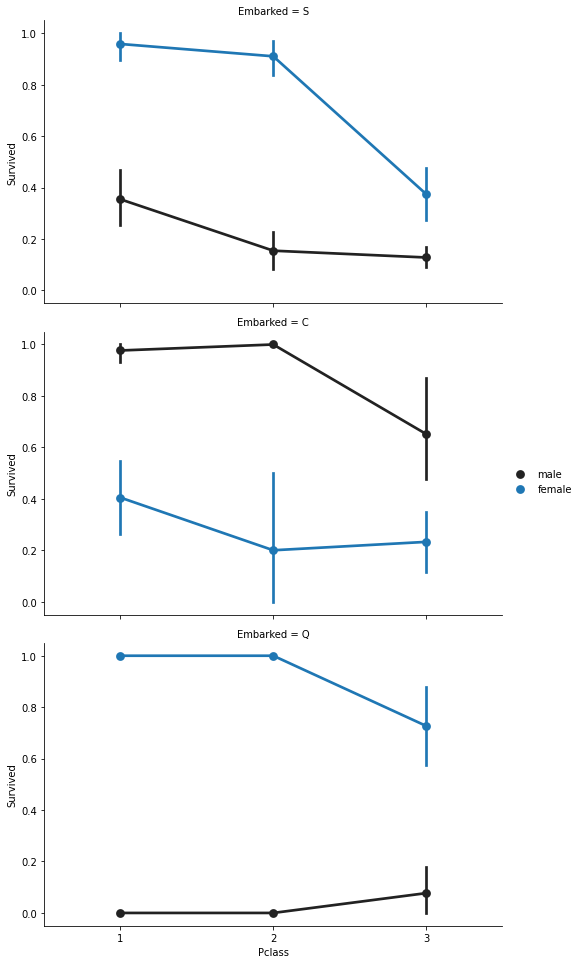

In [86]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender.
Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.
Pclass also seems to be correlated with survival. We will generate another plot of it below.

###Pclass

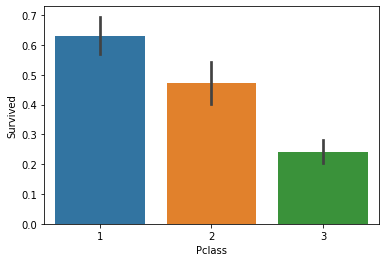

In [87]:
sns.barplot(x='Pclass', y='Survived', data=train_data)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


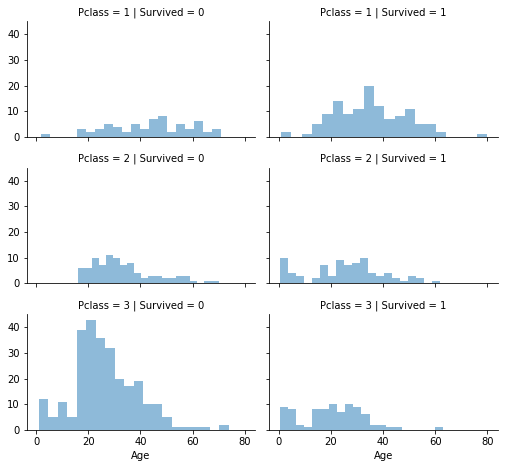

In [88]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

###SibSp and Parch

`SibSp` and `Parch` would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [89]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


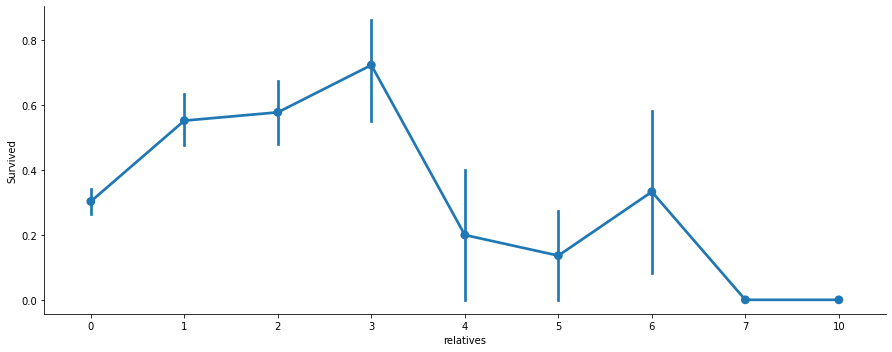

In [90]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5, )

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

##Data Prepocessing

First, I will drop `PassengerId` from the train set, because it does not contribute to a persons survival probability. I will not drop it from the test set, since it is required there for the submission.

In [91]:
train_data = train_data.drop(['PassengerId'], axis=1)

###Missing Data

####Cabin

As a reminder, we have to deal with `Cabin` (687), `Embarked` (2) and `Age` (177). First I thought, we have to delete the `Cabin` variable but then I found something interesting. A cabin number looks like `C123` and the **letter refers to the deck**. Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero. In the picture below you can see the actual decks of the titanic, ranging from `A` to `G`.

In [92]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_data, test_data]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

####Age

Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and `is_null`.

In [93]:
data = [train_data, test_data]

for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)
train_data["Age"].isnull().sum()

0

####Embarked

Since the `Embarked` feature has only 2 missing values, we will just fill these with the most common one.

In [94]:
train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [95]:
common_value = 'S'
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

###Converting Features

In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int64  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int64  
 12  Deck       891 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


Above you can see that `Fare` is a float and we have to deal with 4 categorical features: `Name`, `Sex`, `Ticket` and `Embarked`. Lets investigate and transfrom one after another.

####Fare

Converting `Fare` from float to int64, using the `astype()` function pandas provides:

In [97]:
data = [train_data, test_data]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

####Name

We will use the `Name` feature to extract the `Titles` from the `Name`, so that we can build a new feature out of that.

In [98]:
data = [train_data, test_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

####Sex

Convert `Sex` feature into numeric.

In [99]:
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

####Ticket

In [100]:
train_data['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

Since the `Ticket` attribute has 681 

1.   List item
2.   List item

unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [101]:
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

####Embarked

Convert `Embarked` feature into numeric.

In [102]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

###Creating Categories

We will now create categories within the following features:

####Age

Now we need to convert the `Age` feature. First we will convert it from float into integer. Then we will create the new `AgeGroup` variable, by categorizing every age into a group. Note that it is important to place attention on how you form these groups, since you don’t want for example that 80% of your data falls into group 1.

In [103]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

####Fare

For the `Fare` feature, we need to do the same as with the `Age` feature. But it isn’t that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn `qcut()` function, that we can use to see, how we can form the categories.

In [104]:
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,2,1,0,7,0,1,0,8,1
1,1,1,1,5,1,0,71,1,1,0,3,3
2,1,3,1,3,0,0,7,0,0,1,8,2
3,1,1,1,5,1,0,53,0,1,0,3,3
4,0,3,0,5,0,0,8,0,0,1,8,1
5,0,3,0,6,0,0,8,2,0,1,8,1
6,0,1,0,6,0,0,51,0,0,1,5,1
7,0,3,0,0,3,1,21,0,4,0,8,4
8,1,3,1,3,0,2,11,0,2,0,8,3
9,1,2,1,1,1,0,30,1,1,0,8,3


In [105]:
data = [train_data, test_data]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

###Creating new Features

I will add two new features to the dataset, that I compute out of other features.

####Age times Class

In [106]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

####Fare per Person

In [107]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,6,0,0,1,2,0,1,8,1,18,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


##Building Machine Models

Now we will train several Machine Learning models and compare their results. Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.

In [108]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

###Linear Support Vector Machine

In [110]:
from sklearn.svm import SVC, LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train), 2)
acc_linear_svc

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.81

###Kernel `rbf` SVM

In [111]:
kernel_svc = SVC(kernel='rbf')
kernel_svc.fit(X_train, Y_train)

Y_pred = kernel_svc.predict(X_test)

acc_kernel_svc = round(kernel_svc.score(X_train, Y_train), 2)
acc_kernel_svc

0.82

###Polynomial SVM

In [114]:
polynomial_svc = SVC(kernel='poly')
polynomial_svc.fit(X_train, Y_train)

Y_pred = polynomial_svc.predict(X_test)

acc_polynomial_svc = round(polynomial_svc.score(X_train, Y_train), 2)
acc_polynomial_svc

0.81